# Data Challenge  - James Arnemann (SparkBeyond 4/23/19)

## Problem Summary
#### Overview
From Kaggle: Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus. 

#### Specification
From SparkBeyond: This exercise requires you to explore/clean the datasets, engineer features, develop and evaluate one or more predictive models, and present your work.  Please focus on the interpretation of the model and the practical insights that can be gleaned from the model and any features you have engineered.  Be prepared to discuss your process for feature engineering, as well as the impact the features have on the model.

#### Organization
This notebook is organized into sections as follows:
1. Data exploration
2. Modeling 
3. Discussion
4. Conclusion

In [355]:
#imports used for this challenge
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import folium
import itertools
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

%matplotlib inline

# Data exploration
Here, we:
* Read in data and do basic tests to understand how the data are organized
* Clean / Preprocess the data for later use

In [95]:
# mosquito trap data
trap_df = pd.read_csv('train.csv')
trap_df['Date'] = pd.to_datetime(trap_df['Date']).apply(lambda t: t.date())

trap_df['year'] = trap_df['Date'].apply(lambda d:d.year)
trap_df['day_of_year'] = trap_df['Date'].apply(lambda d:d.timetuple().tm_yday)

trap_df['dummy_count'] = 1

In [147]:
# weather data
weather_df = pd.read_csv('weather.csv')
weather_df['Date'] = pd.to_datetime(weather_df['Date']).apply(lambda t: t.date())

In [17]:
trap_df.head(5)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [6]:
weather_df.head(5)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [18]:
# view unique values of mosquito trap data
for col in trap_df.columns:
    print(col,trap_df[col].dtype, np.sort(trap_df[col].unique()))
    print('--------------\n')

Date object [datetime.date(2007, 5, 29) datetime.date(2007, 6, 5)
 datetime.date(2007, 6, 26) datetime.date(2007, 6, 29)
 datetime.date(2007, 7, 2) datetime.date(2007, 7, 11)
 datetime.date(2007, 7, 18) datetime.date(2007, 7, 19)
 datetime.date(2007, 7, 25) datetime.date(2007, 7, 27)
 datetime.date(2007, 8, 1) datetime.date(2007, 8, 2)
 datetime.date(2007, 8, 3) datetime.date(2007, 8, 7)
 datetime.date(2007, 8, 8) datetime.date(2007, 8, 9)
 datetime.date(2007, 8, 15) datetime.date(2007, 8, 16)
 datetime.date(2007, 8, 17) datetime.date(2007, 8, 21)
 datetime.date(2007, 8, 22) datetime.date(2007, 8, 24)
 datetime.date(2007, 8, 28) datetime.date(2007, 9, 4)
 datetime.date(2007, 9, 5) datetime.date(2007, 9, 6)
 datetime.date(2007, 9, 12) datetime.date(2007, 9, 18)
 datetime.date(2007, 9, 19) datetime.date(2007, 9, 24)
 datetime.date(2007, 9, 25) datetime.date(2007, 10, 4)
 datetime.date(2007, 10, 9) datetime.date(2009, 5, 28)
 datetime.date(2009, 6, 2) datetime.date(2009, 6, 3)
 datetime.d

In [153]:
# clean up weather data codes (split strings by code)

code_quantifiers = ['VC','MI','BC','+','-'] 
def replace_all(s,list_of_strings,new_string):
    for l in list_of_strings:
        s = s.replace(l,new_string)
    return s
weather_df['CodeSum'] = weather_df['CodeSum'].apply(lambda s: replace_all(s,code_quantifiers,''))
weather_df['CodeSum'] = weather_df['CodeSum'].apply(lambda s: s.replace('TSRA','TS RA'))
weather_df['CodeSum'].unique()

weather_df['CodeSum_list'] = weather_df['CodeSum'].apply(lambda s: [] if s == ' ' else s.split(' '))

weather_codes = set({})

for l in weather_df["CodeSum_list"]:
    weather_codes.update(l)
    
for code in weather_codes:
    weather_df[code] = weather_df['CodeSum_list'].apply(lambda s: 1 if code in s else 0)

weather_df = weather_df.drop(['CodeSum_list'],axis=1)

In [170]:
# clean missing data and replace trace values with values corresponding to data precision
weather_df = weather_df.replace('M', np.nan)
weather_df['SnowFall'] = weather_df['SnowFall'].replace('  T','0.01')
weather_df['PrecipTotal'] = weather_df['PrecipTotal'].replace('  T','0.001')

In [176]:
# remove empty columns
weather_df = weather_df.drop(['Depth','Water1'],axis=1)

In [182]:
# view unique values of cleaned weather data
for col in weather_df.columns:
    print(col,weather_df[col].dtype, weather_df[col].unique())
    print('--------------\n')

Station int64 [1 2]
--------------

Date object [datetime.date(2007, 5, 1) datetime.date(2007, 5, 2)
 datetime.date(2007, 5, 3) ... datetime.date(2014, 10, 29)
 datetime.date(2014, 10, 30) datetime.date(2014, 10, 31)]
--------------

Tmax int64 [ 83  84  59  60  66  67  78  68  82  80  77  76  70  73  64  65  69  90
  62  61  71  79  87  89  88  75  85  86  81  72  63  91  92  93  74  94
  54  53  56  57  58  55  50  95  52  47  45  51  48  44  49  46  96  99
 100 101  97  98 102 103 104  42  41]
--------------

Tmin int64 [50 52 42 43 46 48 49 51 53 54 47 60 61 63 56 59 44 57 45 55 66 65 70 68
 62 67 64 58 71 69 73 75 72 74 39 41 40 37 34 38 35 36 33 31 32 76 77 29
 78 79 80 81 82 83]
--------------

Tavg float64 [67. 68. 51. 52. 56. 58. nan 60. 59. 65. 70. 69. 71. 61. 55. 57. 73. 72.
 53. 62. 63. 74. 75. 78. 76. 77. 66. 80. 64. 81. 82. 79. 85. 84. 83. 50.
 49. 46. 48. 45. 54. 47. 44. 40. 41. 38. 39. 42. 37. 43. 86. 87. 89. 92.
 88. 91. 93. 94. 90. 36.]
--------------

Depart float64 

In [172]:
# convert values of weather data to float
recast_column_list = ['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']
for col in recast_column_list:
    weather_df[col] = weather_df[col].astype(float)

In [318]:
# extract data associated with traps at each location (for map below)
gby_count_trap_df = train_df.groupby(['Latitude','Longitude']).sum().reset_index()

In [871]:
# plot each trap's location as a circle on a map
# the radius indicates the number of observations for the trap
map_traps = folium.Map(location=[gby_count_trap_df['Latitude'].mean(),gby_count_trap_df['Longitude'].mean()],tiles='OpenStreetMap',
 zoom_start=10)
for each in gby_count_trap_df.iterrows():

    folium.CircleMarker([each[1]['Latitude'],each[1]['Longitude']],
                        radius=100*each[1]['dummy_count']/(gby_count_trap_df['dummy_count'].max()),
                        alpha = .2,
                        color='blue',
                        popup= 'lat, long: (' + str(each[1]['Latitude'])+','+str(each[1]['Longitude'])+') Count:'+str(each[1]['dummy_count']) + ' Avg_Num_Mosq: ' + str(each[1]['NumMosquitos']/each[1]['dummy_count']) + ' Ratio_WNV_present: ' + str(each[1]['WnvPresent']/each[1]['dummy_count']),
                        fill_color='#FD8A6C'
                        ).add_to(map_traps)
map_traps

In [53]:
# average number of mosquitos caught in trap
gby_count_trap_df['avg_num_mosquitos'] = gby_count_trap_df['NumMosquitos']/gby_count_trap_df['dummy_count']
np.corrcoef(gby_count_trap_df['dummy_count'],gby_count_trap_df['avg_num_mosquitos'])

array([[1.        , 0.62746785],
       [0.62746785, 1.        ]])

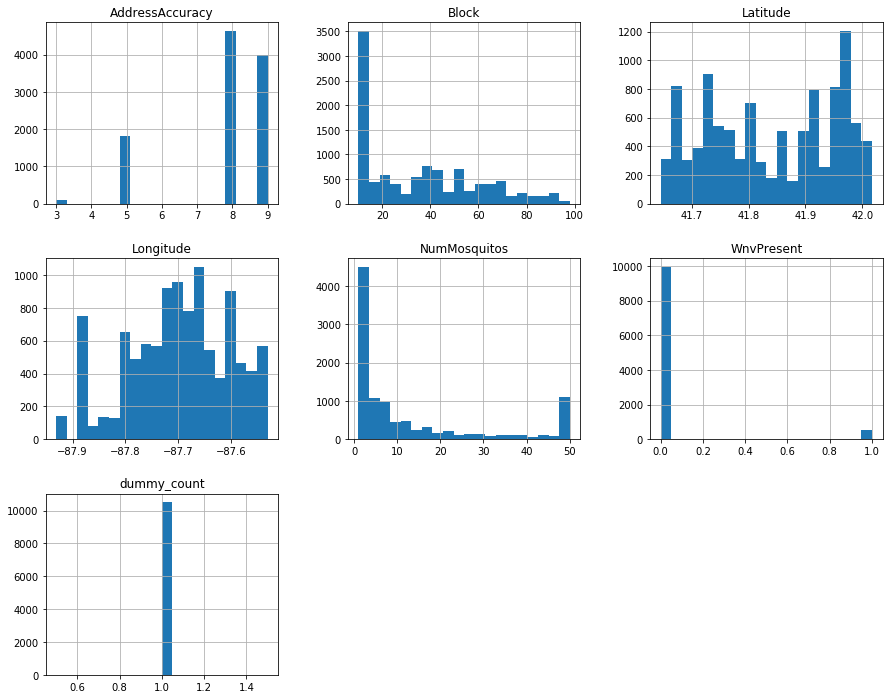

In [60]:
# show distribution of trap data
trap_df.hist(figsize=(15,12),bins=20)
plt.show()

In [65]:
# infomation about each mosquito species
species_gby = trap_df.groupby('Species').sum()
species_gby['ratio_wnv_found'] = species_gby['WnvPresent']/species_gby['dummy_count']

In [732]:
species_gby[['NumMosquitos','WnvPresent','ratio_wnv_found']]

,NumMosquitos,WnvPresent,ratio_wnv_found
Species,,,
CULEX ERRATICUS,7,0,0.000000
CULEX PIPIENS,44671,240,0.088922
CULEX PIPIENS/RESTUANS,66268,262,0.055135
CULEX RESTUANS,23431,49,0.017883
CULEX SALINARIUS,145,0,0.000000
CULEX TARSALIS,7,0,0.000000
CULEX TERRITANS,510,0,0.000000


In [184]:
# coordinates of weather stations used to collect weather data in latitude and longitude
station1_coords = (41.995,-87.933)
station2_coords = (41.786,-87.752)

In [224]:
# get unique traps
trap = {}
for trap_id in trap_df['Trap'].unique():
    trap[trap_id] = trap_df[(trap_df['Trap'] == trap_id)]

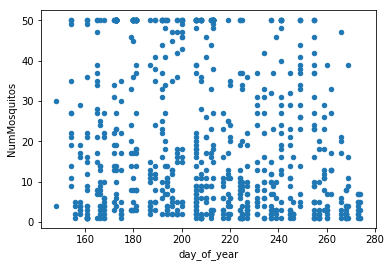

In [207]:
# looks like the trap maxes out at 50
trap = {}
trap['T900'] = trap_df[(trap_df['Trap'] == 'T900')]
trap['T900'].plot(x='day_of_year',y='NumMosquitos',kind='scatter')

In [731]:
# shows the maximum number of mosquitos that a trap can collect
trap_df['NumMosquitos'].max()

50

Trap with largest count at O'Hair


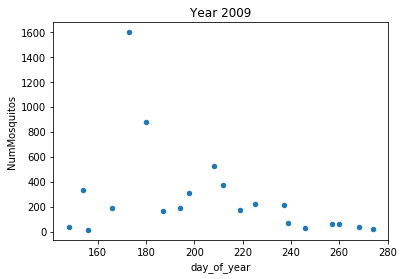

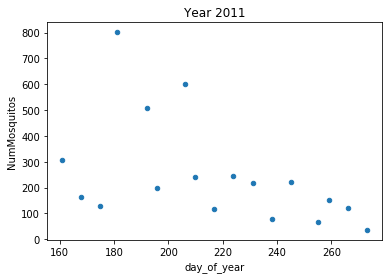

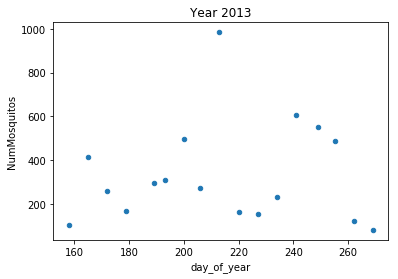

In [237]:
# show total number of mosquitos over time for an example trap
print("Trap with largest count at O'Hair")
trap_id = 'T900'
for year in trap[trap_id]['year'].unique():
    trap[trap_id][(trap[trap_id]['year']==year)].groupby('day_of_year').sum().reset_index().plot(x='day_of_year', y= 'NumMosquitos',kind='scatter')
    plt.title('Year ' + str(year))
    plt.show()

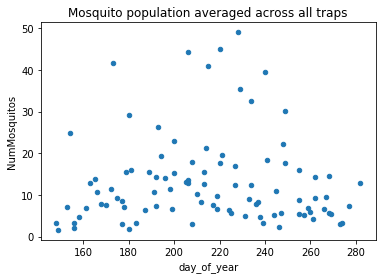

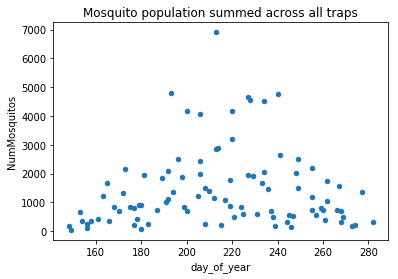

In [730]:
# average and total number of mosquitos over time
trap_df.groupby(['Date','day_of_year']).mean().reset_index().plot(x='day_of_year',y='NumMosquitos',kind='scatter')
plt.title('Mosquito population averaged across all traps')
plt.show()

trap_df.groupby(['Date','day_of_year']).sum().reset_index().plot(x='day_of_year',y='NumMosquitos',kind='scatter')
plt.title('Mosquito population summed across all traps')
plt.show()

In [229]:
trap_ids = list(trap.keys())

T094


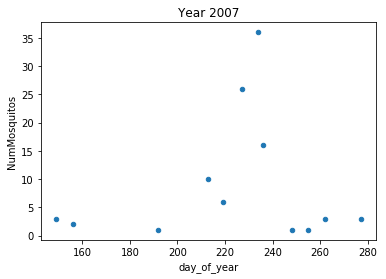

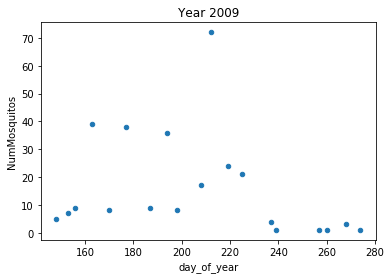

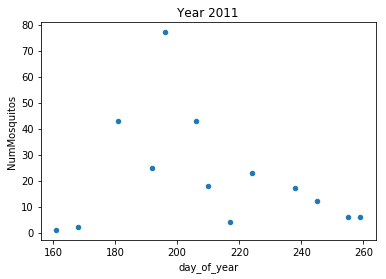

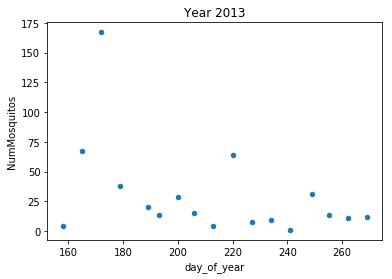

In [236]:
# examine an example trap
trap_id = trap_ids[11]
print(trap_id)
for year in trap[trap_id]['year'].unique():
    trap[trap_id][(trap[trap_id]['year']==year)].groupby('day_of_year').sum().reset_index().plot(x='day_of_year', y= 'NumMosquitos',kind='scatter')
    plt.title('Year ' + str(year))
    plt.show()

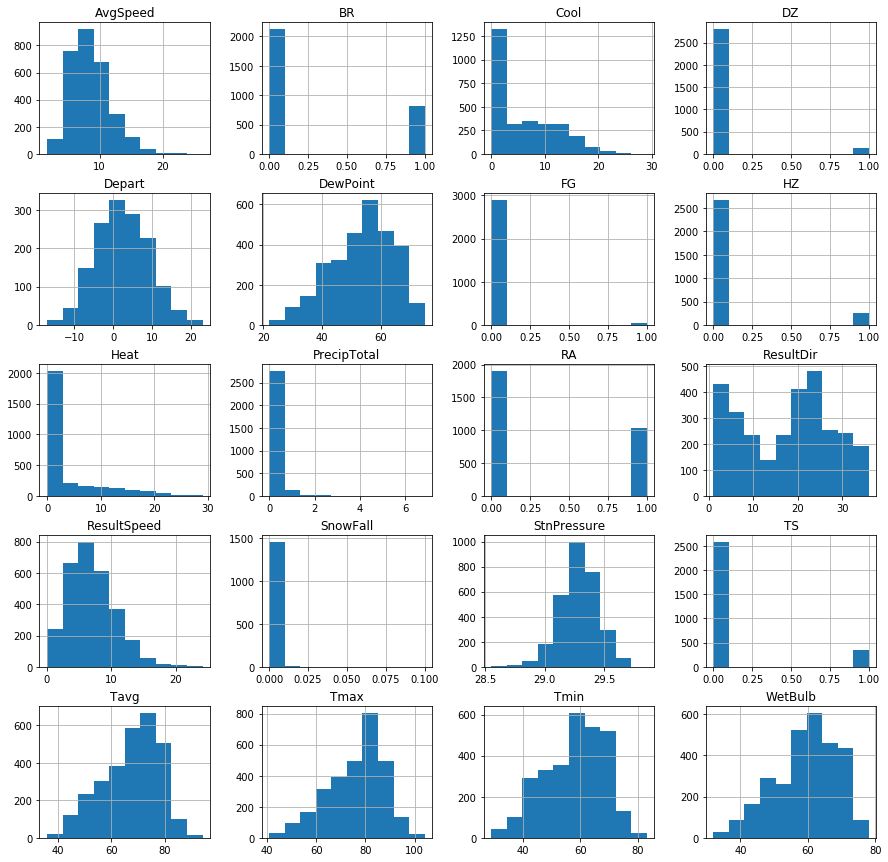

In [713]:
# show distribution of weather data
weather_hist_cols = ['Tmin', 'Tavg', 'Tmax', 'Depart', 'DewPoint','WetBulb', 'Heat', 'Cool', 'SnowFall','PrecipTotal', 'StnPressure', 'ResultSpeed', 'ResultDir','AvgSpeed', 'DZ', 'BR', 'FG', 'HZ', 'TS', 'RA']
weather_df[weather_hist_cols].hist(figsize = (15,15))
plt.show()

In [270]:
# make a timeseries for each trap
trap_ts = {}
trap_ts['NumMosquitos'] = trap_df.pivot_table(values=['NumMosquitos','WnvPresent'],index= 'Date',columns=['Trap'],aggfunc=['sum','mean'])['sum']['NumMosquitos']
trap_ts['WnvPresent'] = trap_df.pivot_table(values=['NumMosquitos','WnvPresent'],index= 'Date',columns=['Trap'],aggfunc=['sum','mean'])['mean']['WnvPresent']

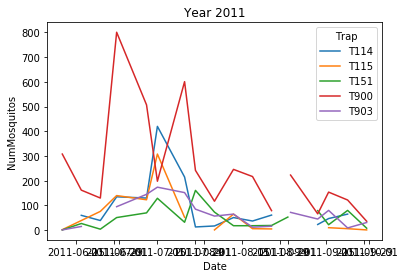

In [857]:
# plot the timeseries for the traps with the most observations of mosquitos
year = 2011
cutoff = 800
total_mosquitos = trap_ts['NumMosquitos'].reset_index()
total_mosquitos = testing1[testing1['Date'].apply(lambda d: d.year) == year]
total_mosquitos[['Date']+ list(np.array(total_mosquitos.columns[1:])[total_mosquitos.sum()>cutoff])].plot(x='Date', y=list(np.array(total_mosquitos.columns[1:])[total_mosquitos.sum()>cutoff]))
plt.ylabel('NumMosquitos')
plt.title('Year ' + str(year))
plt.show()

In [553]:
# set up data for models
gby_trap_df = trap_df.groupby(['Date','year','day_of_year','Trap']).mean().reset_index()
gby_trap_df = gby_trap_df[['Date','year','day_of_year','Trap','NumMosquitos','WnvPresent']]
gby_trap_df['WnvPresent'] = gby_trap_df['WnvPresent'].apply(lambda x: 1 if x>0 else 0)

#use average weather data
gby_trap_df = gby_trap_df.merge(weather_df.groupby('Date').mean().reset_index(),on='Date',how='left')

In [858]:
# obtain weather history for 2 weeks prior to each observation
for day_diff in range(14):
    weather_temp_df = weather_df.copy()
    weather_temp_df['Date'] = weather_temp_df['Date'].apply(lambda d: d - datetime.timedelta(days=day_diff))
    gby_trap_df = gby_trap_df.merge(weather_temp_df.groupby('Date').mean().reset_index(),how='left',on='Date',suffixes=('',('_'+str(day_diff))))

In [859]:
# break up training and test sets
total_train_df = gby_trap_df[gby_trap_df['year'] !=2013]
test_df = gby_trap_df[gby_trap_df['year']==2013]

In [860]:
# define training and validation testing sets
train_df, val_df = train_test_split(total_train_df, test_size=0.2)

# Modeling
Here, we:
* Use Lasso to predict number of mosquitos
* Use a Random Forest Classifier to predict West Nile presence

## Predict number of mosquitos

training_error 56.76860156557666
val_error 75.4557267469246
-----------
r2_train  0.17760391759814464
r2_val  0.10930884515975958


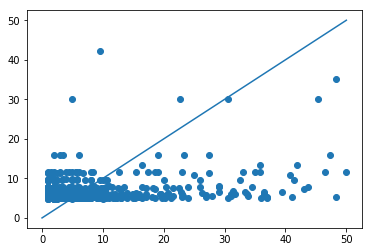

In [863]:
# run a random forest regressor to predict the number of mosquitos
# predictors include 2-weeks of weather data and day of year
features = list(total_train_df.columns[33:])
features.append('day_of_year')

y = train_df['NumMosquitos']

clf = RandomForestRegressor(n_jobs=4, random_state=1, n_estimators = 100, max_depth=4)
#clf = LinearRegression()
#clf = Lasso(alpha=100)

# Train the model to take the training features and learn how they relate
# to the training y
clf.fit(train_df[features], y)

print('training_error',mean_squared_error(y,clf.predict(train_df[features])))
val_y_true = val_df['NumMosquitos']
val_y_predict = clf.predict(val_df[features])
print('val_error', mean_squared_error(val_y_true,val_y_predict))
print('-----------')

from sklearn.metrics import r2_score
print('r2_train ', r2_score(y,clf.predict(train_df[features])))
print('r2_val ', r2_score(val_y_true,val_y_predict))

plt.scatter(val_y_true,val_y_predict)
plt.plot([0,50],[0,50])
plt.show()

In [865]:
# define a function to z-score the data, conditioned on trap ID
def z_score_df(df,col,value):
    subtype_list = list(df[col].unique())
    new_df = pd.DataFrame()
    for subtype in subtype_list:
        mu = df[df[col] == subtype][value].mean()
        sd = df[df[col] == subtype][value].std()
        new_df = new_df.append(pd.DataFrame({col:[subtype],'mean':[mu], 'std':[sd]}))
    return new_df
# mean and stdev for each trap
mosquito_zscore_df = z_score_df(train_df,'Trap','NumMosquitos')

In [866]:
# add mean and stdev information to the training and validation datasets
train_df = train_df.merge(mosquito_zscore_df,how='left', on='Trap')
val_df = val_df.merge(mosquito_zscore_df,how='left', on='Trap')

In [867]:
# z-score number of mosquitos, conditioned on trap ID
train_df['NumMosq_zscore'] = ((train_df['NumMosquitos']-train_df['mean'])/train_df['std'])

training_error 0.7455747655706465
val_error 58.715655146839545
-----------
r2_score for training data:  0.22952621015893615
r2_score for validation data:  0.19609287551572274


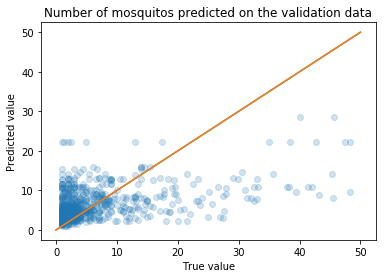

In [818]:
# use only information about the mean number of mosquitos associated with each trap 
# to predict the number of mosquitos
features = list(total_train_df.columns[33:])
features.append('day_of_year')

y = train_df['NumMosq_zscore'].fillna(0.0)

print('training_error',mean_squared_error(y,clf.predict(train_df[features])))
val_y_true = val_df['NumMosquitos']
val_y_predict = (val_df['mean'])
val_y_predict = val_y_predict.fillna(0.0)
print('val_error', mean_squared_error(val_y_true,val_y_predict))
print('-----------')

from sklearn.metrics import r2_score
print('r2_score for training data: ', r2_score(train_df['NumMosquitos'],train_df['mean']))
print('r2_score for validation data: ', r2_score(val_y_true,val_y_predict))

plt.scatter(val_y_true,val_y_predict,alpha=.2)
plt.plot([0,50],[0,50])
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("Number of mosquitos predicted on the validation data")
plt.plot([0,50],[0,50])
plt.show()

/Users/James/anaconda/envs/py3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


training_error 0.7432136007381864
val_error 41.50746977869753
-----------
r2_score for training data:  0.43451892257942426
r2_score for validation data:  0.43169925310444457


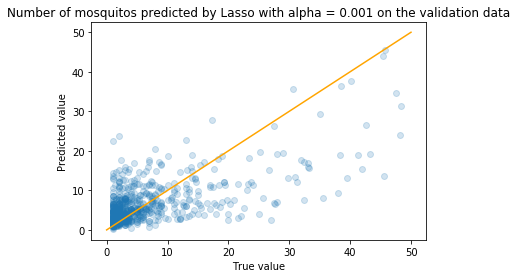

In [817]:
# use lasso regression to predict number of mosquitos on z-scored data
# predictors include 2-weeks of weather data, day of year, and trap information
features = list(total_train_df.columns[33:])
features.append('day_of_year')

y = train_df['NumMosq_zscore'].fillna(0.0)

#clf = RandomForestRegressor(n_jobs=4, random_state=1, n_estimators = 100, max_depth=20)
#clf = LinearRegression()
clf = Lasso(alpha=.001)

# Train the model to take the training features and learn how they relate
# to the training y
clf.fit(train_df[features], y)

print('training_error',mean_squared_error(y,clf.predict(train_df[features])))
val_y_true = val_df['NumMosquitos']
val_y_predict = (val_df['std']*clf.predict(val_df[features])+val_df['mean'])
val_y_predict = val_y_predict.fillna(0.0)
print('val_error', mean_squared_error(val_y_true,val_y_predict))
print('-----------')

from sklearn.metrics import r2_score
print('r2_score for training data: ', r2_score(train_df['NumMosquitos'],(train_df['std'].fillna(0.0)*clf.predict(train_df[features])+train_df['mean'])))
print('r2_score for validation data: ', r2_score(val_y_true,val_y_predict))

plt.scatter(val_y_true,val_y_predict,alpha=.2)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title("Number of mosquitos predicted by Lasso with alpha = 0.001 on the validation data")
plt.plot([0,50],[0,50],c='orange')
plt.show()

## Use classifier to predict WNV

training_accuracy 0.9663287472845764
testing_accuracy 0.9406657018813314
-----------
652 39
Recall:  0.28205128205128205
Precision:  0.4583333333333333
F1 score: 0.34920634920634913
Confusion matrix, without normalization
[[639  13]
 [ 28  11]]


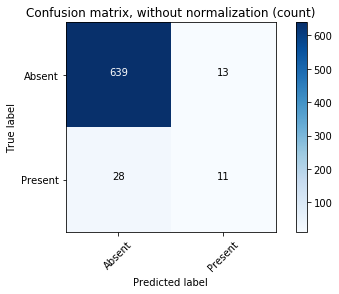

Normalized confusion matrix
[[0.98 0.02]
 [0.72 0.28]]


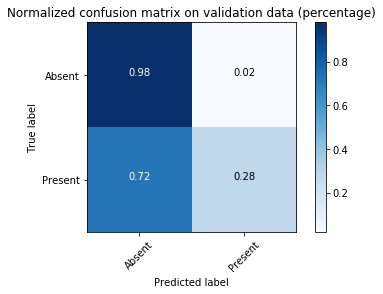

Recall:  0.28205128205128205
Precision:  0.4583333333333333
F1 score: 0.34920634920634913


In [833]:
# use a random forest classifier to predict the cases of WNV
# on training and validation data

# predictors
features = ['Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'SN', 'FU', 'SQ', 'DZ', 'GR',
       'BR', 'FG', 'HZ', 'TS', 'RA','NumMosquitos']
features.append('day_of_year')

y = train_df['WnvPresent']

# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_jobs=4, random_state=1, n_estimators = 100, max_depth=10)
#clf = LogisticRegression()

# Train the Classifier to take the training features and learn how they relate
# to the training y
clf.fit(train_df[features], y)

print('training_accuracy',np.sum(clf.predict(train_df[features]) == train_df['WnvPresent'])/len(train_df))
print('testing_accuracy',np.sum(clf.predict(val_df[features]) == val_df['WnvPresent'])/len(val_df))

print('-----------')

y_test = val_df['WnvPresent']
y_pred = clf.predict(val_df[features])

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix[0].sum(),cnf_matrix[1].sum())

recall = cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[1][0])
precision = cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[0][1])
F1 = 2*recall*precision/(recall+precision)

print('Recall: ', recall)
print('Precision: ', precision)
print('F1 score:', F1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization (count)')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix on validation data (percentage)')

plt.show()

#print(y_test)
#print(y_pred)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.astype(float), y_pred.astype(float))

recall = cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[1][0])
precision = cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[0][1])
F1 = 2*recall*precision/(recall+precision)

print('Recall: ', recall)
print('Precision: ', precision)
print('F1 score:', F1)

Confusion matrix, without normalization
[[988   6]
 [162   7]]


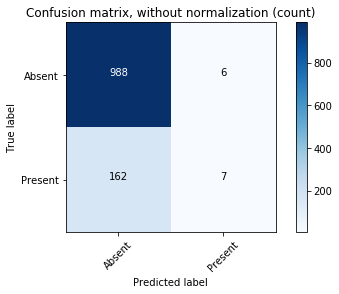

Normalized confusion matrix
[[0.99 0.01]
 [0.96 0.04]]


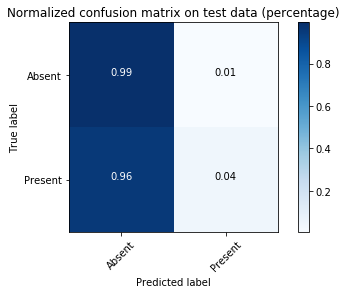

Recall:  0.04142011834319527
Precision:  0.5384615384615384
F1 score: 0.07692307692307693


In [834]:
# use a random forest classifier to predict the cases of WNV
# on test data

y_test = test_df['WnvPresent']
y_pred = clf.predict(test_df[features].fillna(0.0))

class_names = ['Absent','Present']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization (count)')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix on test data (percentage)')

plt.show()

recall = cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[1][0])
precision = cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[0][1])
F1 = 2*recall*precision/(recall+precision)

print('Recall: ', recall)
print('Precision: ', precision)
print('F1 score:', F1)

In [827]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),         \
                 horizontalalignment="center",        \
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[611  41]
 [  8  31]]


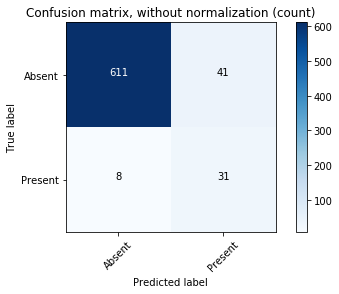

Normalized confusion matrix
[[0.94 0.06]
 [0.21 0.79]]


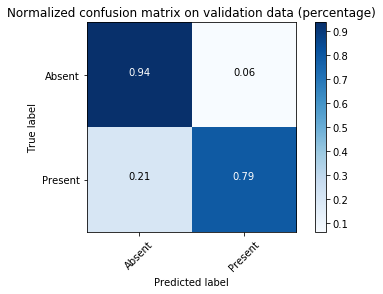

Threshold:  0.18
Recall:  0.7948717948717948
Precision:  0.4305555555555556
F1 score: 0.5585585585585585


In [847]:
# adjust the threshold of the classifier
threshold = 0.18
y_test = val_df['WnvPresent']
probas_ = clf.predict_proba(val_df[features])

y_pred = (probas_[:,1] >= threshold).astype('int')

class_names = ['Absent','Present']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization (count)')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix on validation data (percentage)')

plt.show()

recall = cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[1][0])
precision = cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[0][1])
F1 = 2*recall*precision/(recall+precision)
print('Threshold: ', threshold)
print('Recall: ', recall)
print('Precision: ', precision)
print('F1 score:', F1)

Confusion matrix, without normalization
[[810 184]
 [ 75  94]]


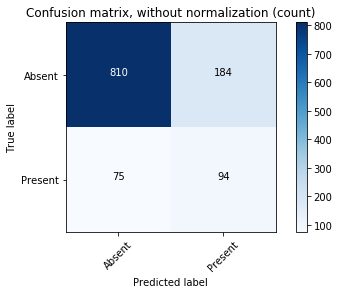

Normalized confusion matrix
[[0.81 0.19]
 [0.44 0.56]]


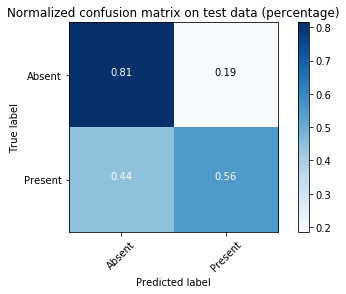

Threshold:  0.18
Recall:  0.5562130177514792
Precision:  0.3381294964028777
F1 score: 0.4205816554809843


In [848]:
# use the adjusted threshold on the test data
y_test = test_df['WnvPresent']
probas_ = clf.predict_proba(test_df[features])

y_pred = (probas_[:,1] >= threshold).astype('int')

class_names = ['Absent','Present']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization (count)')
plt.show()

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix on test data (percentage)')

plt.show()

recall = cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[1][0])
precision = cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[0][1])
F1 = 2*recall*precision/(recall+precision)

print('Threshold: ', threshold)
print('Recall: ', recall)
print('Precision: ', precision)
print('F1 score:', F1)

# Discussion

We evaluate the performance of the random forest classifier by looking at the AUC of the ROC

In [839]:
probas_ = clf.predict_proba(val_df[features])
fpr, tpr, thresholds = roc_curve(val_df['WnvPresent'], probas_[:, 1])

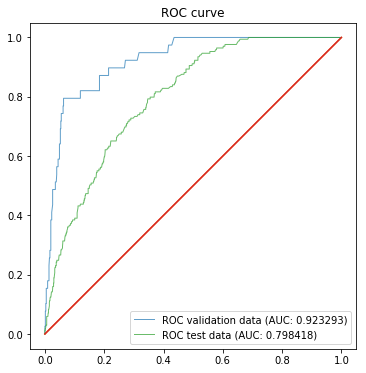

In [840]:
# plot the ROC of the final random forest classifier

plt.figure(figsize=(6,6))

probas_ = clf.predict_proba(val_df[features])
fpr, tpr, thresholds = roc_curve(val_df['WnvPresent'], probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.7,label='ROC validation data (AUC: %f)'%(roc_auc))
plt.plot([0,1],[0,1])

probas_ = clf.predict_proba(test_df[features])
fpr, tpr, thresholds = roc_curve(test_df['WnvPresent'], probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.7,label='ROC test data (AUC: %f)'%(roc_auc))
plt.plot([0,1],[0,1])
plt.gca().set_aspect('equal', adjustable='box')

plt.legend()
plt.title('ROC curve')
plt.show()

# Conclusion

In conclusion we were able to tell a good deal about the number of mosquitos in a given trap location and whether West Nile was present.  Some important take aways were that:
* Using day of year and trap identity we could achieve most of the explanation of variance, and when adding weather data we could acheive an R_2 of .43 for prediction of number of mosquitos
* Using a Random Forest Classifier to predict presents of West Nile with weather data and number of mosquitos we were able to achieve an F1 score of 0.42 and AUC of the ROC of 0.80 over the the test set

If I had more time we could take into account previous trap information to predict present data, as well as other useful features.